In [ ]:
!pip3 install pandas==1.3.4

In [ ]:
!pip install 'umap-learn==0.3.10'

In [ ]:
!pip3 install Xlsxwriter

In [ ]:
import pandas as pd
import os

In [ ]:
!pip3 install pickle5

In [ ]:
'''Executed on Google Colab'''
#from google.colab import drive
#drive.mount('/content/gdrive')
path = '../output'

Mounted at /content/gdrive


In [ ]:
import pickle5 as pickle
with open(os.path.join(path,'07142022_clean_data.pkl'), "rb") as fh:
  df_comments = pickle.load(fh)

In [ ]:
sentences = df_comments.lemmasNgrams.values

In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
bigram = Phrases(sentences, min_count=1, threshold=3, delimiter=b'_')  
bigram_phraser = Phraser(bigram)

In [ ]:
df_comments['lemmasNgrams']=None
i=0
for sent in sentences:
    df_comments.at[i, 'lemmasNgrams'] = bigram_phraser[sent]
  i=i+1

In [ ]:
df_comments[['lemmas','lemmasNgrams']].head(5)

In [ ]:
lemmaSenetence = df_comments.noun_phrases.values

In [ ]:
lemmaSenetence

Topic Models Evaluation

In [ ]:
from gensim.models import word2vec, FastText
from gensim.models import KeyedVectors

In [ ]:
model = word2vec.Word2Vec(lemmaSenetence, size=50, min_count=3, iter=20) # Original Used Model

In [ ]:
modelFastText = word2vec.Word2Vec(lemmaSenetence, size=50, min_count=3, iter=20, sg=1) # Benchmarked Model

In [ ]:
model.wv.most_similar_cosmul('rape', topn= 5)

[('getting_rape', 0.8753862380981445),
 ('got_rape', 0.8734113574028015),
 ('attempt_rape', 0.8680598139762878),
 ('try_rape', 0.8567650318145752),
 ('poor', 0.8327734470367432)]

In [ ]:
model.wv.most_similar('joy', topn =10)

In [ ]:
modelFastText.most_similar('funny', topn=10)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import plotly.express as px
import plotly.graph_objs as go

In [ ]:
reducer = UMAP(n_components=2, metric='cosine', n_neighbors = 5, min_dist=0.1)
words = model.wv.vocab
wv_ = [model[word] for word in words]

In [ ]:
"""Find the closest word in a given list of search words, if in top-n."""
def closest(word, model, search, topn):
  closest_word = model.wv.most_similar_to_given(word, search)     
  if word == closest_word or \
           word in [w for w, _ in model.wv.most_similar(closest_word, topn=5)]:
    return closest_word 
  else:
    return 'other'      

In [ ]:
reduced_wv = reducer.fit_transform(wv_)

In [ ]:
df = pd.DataFrame.from_records(reduced_wv, columns=['x', 'y'])

In [ ]:
df['word']  = words
params = {}
df['size'] = df['word'].map(lambda w: 30 if w in search else 5) 
params.update({'size': 'size'})
labels=False
df['label'] = df['word'].map(lambda w: w if labels or w in search else '')
params.update({'text': 'label'})
colors=True
df['color'] = df['word'].apply(closest, model=model, search=search, topn=5)
params.update({'color': 'color'})

In [ ]:
params.update({'width': 800, 'height': 400})
fig = px.scatter(df, x="x", y="y", opacity=0.3, **params)
fig.update_xaxes(showticklabels=False, showgrid=True, title='', zeroline=False, visible=True)
fig.update_yaxes(showticklabels=False, showgrid=True, title='', zeroline=False, visible=True)
fig.update_traces(textposition='middle center', marker={'line': {'width': 0}})
fig.update_layout(font=dict(family="Franklin Gothic", size=12, color="#000000"))
fig.show()

In [ ]:
def plot_embeddings(model, search=[], topn=0, show_all=False, train_all=False, 
                    labels=False, colors=True, n_dims=2, algo='pca', **kwargs):

    def closest(word, model, search, topn):
        """Find the closest word in a given list of search words, if in top-n."""
        closest_word = model.wv.most_similar_to_given(word, search)
        if word == closest_word or \
           word in [w for w, _ in model.wv.most_similar(closest_word, topn=topn)]:
            return closest_word 
        else:
            return 'other'

    # eliminate kwargs of other methods if supplied
    if algo != 'tsne': ###
        kwargs.pop('perplexity', None) ###
    if algo != 'umap': ###
        kwargs.pop('n_neighbors', None) ###
        kwargs.pop('min_dist', None) ###
        kwargs.pop('spread', None) ###

    # define the reducer
    if algo == 'umap':
        reducer = UMAP(n_components=n_dims, metric='cosine', **kwargs)
    elif algo == 'tsne':
        reducer = TSNE(n_components=n_dims, **kwargs)
    else:
        reducer = PCA(n_components=n_dims, **kwargs)

    if len(search) == 0: # no search words: show all
        show_all = True
    if show_all:  # to show all, all must be trained
        train_all = True
        
    # identify words to plot
    if show_all:
        words = [w for w in model.wv.vocab]
    else:
        words = search + [sim_word for w in search 
                         for sim_word, _ in model.wv.most_similar(w, topn=topn)]
        words = list(set(words)) # make word list it unique for t-SNE

    # reduce
    wv = [model[word] for word in words]
    if not train_all:
        print(f"Calculating {algo} for {len(words)} words ...", end="") 
        reduced_wv = reducer.fit_transform(wv)
    else:
        print(f"Calculating {algo} for {len(model.wv.vocab)} words ...", end="") 
        reducer.fit(model.wv.vectors)
        reduced_wv = reducer.transform(wv)
    print(f" done.") ###

    # create data frame for ploty express visualization
    # with x, y (, z) and meta data for styling
    if n_dims == 2:
        df = pd.DataFrame.from_records(reduced_wv, columns=['x', 'y'])
    else:
        df = pd.DataFrame.from_records(reduced_wv, columns=['x', 'y', 'z'])

    df['word']  = words
    params = {}

    if show_all:
        df['size'] = 1
        params.update({'size_max': 3, 'size': 'size' })
    else:
        df['size'] = df['word'].map(lambda w: 30 if w in search else 5)
        params.update({'size': 'size'})

    if len(search) > 0: # colorize with closest search word
        df['label'] = df['word'].map(lambda w: w if labels or w in search else '')
        params.update({'text': 'label'})
        if colors:
            df['color'] = df['word'].apply(closest, model=model, search=search, topn=topn)
            params.update({'color': 'color'})

    #params.update({'hover_data': {c: False for c in df.columns}, 'hover_name': 'word'})

    # generate scatter plot
    if n_dims == 2:
        params.update({'width': 900, 'height': 500})
        fig = px.scatter(df, x="x", y="y", opacity=0.3, **params)
        fig.update_xaxes(showticklabels=False, showgrid=True, title='', zeroline=False, visible=True)
        fig.update_yaxes(showticklabels=False, showgrid=True, title='', zeroline=False, visible=True)
    else:
        params.update({'width': 900, 'height': 900})
        df['z'] = df['z']*2/3 # scale 3d box
        fig = px.scatter_3d(df, x="x", y="y", z="z", opacity=0.5, **params)
        fig.update_layout(scene = dict(xaxis = go.layout.scene.XAxis(title = '', showticklabels=False),
                                       yaxis = go.layout.scene.YAxis(title = '', showticklabels=False),
                                       zaxis = go.layout.scene.ZAxis(title = '', showticklabels=False)))
    fig.update_traces(textposition='middle center', marker={'line': {'width': 0}})
    fig.update_layout(font=dict(family="Franklin Gothic", size=10, color="#000000"))
    #fig.show()
    return fig

In [ ]:
search =['joy','fear', 'disgust', 'anger', 'surprise', 'compassion']
plot_embeddings(modelFastText, search, topn=10, show_all=False, labels=True, algo='umap', n_neighbors=15, min_dist=10, spread=25)

In [ ]:
search =['battery','screen','volume','memory','return_policy','customer_service','value','durable','network','freeze','camera','design','user_interface','security']
plot_embeddings(model, search, topn=5, show_all=False, labels=True, algo='umap', n_neighbors=15, min_dist=10, spread=25)

In [ ]:
import networkx as nx
import collections

In [ ]:
collections.deque

collections.deque

In [ ]:
def sim_tree(model, word, top_n, max_dist):
 graph = nx.Graph()
 graph.add_node(word, dist=0)
 to_visit = collections.deque([word])
 while len(to_visit) > 0:
   source = to_visit.popleft() # visit next node
   dist = graph.nodes[source]['dist']+1
   if dist <= max_dist: # discover new nodes
      for target, sim in model.wv.most_similar(source, topn=top_n):
        if target not in graph:
          to_visit.append(target)
          graph.add_node(target, dist=dist)
          graph.add_edge(source, target, sim=sim, dist=dist)
 return graph


In [ ]:
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
def plot_tree(graph, node_size=1000, font_size=12):
  pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])
  colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
  nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors, cmap=plt.get_cmap('viridis'), alpha=0.4)
  nx.draw_networkx_labels(graph, pos, font_size=font_size)
  for (n1, n2, sim) in graph.edges(data='sim'):
    nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)
  #plt.show()


In [ ]:
plt.figure(figsize=(30,15))
graph = sim_tree(model, 'dodson', top_n=5, max_dist=3)
img = plot_tree(graph, node_size=800, font_size=16)
plt.savefig(os.path.join(path, 'line plot.png'),bbox_inches='tight', dpi=300)

In [ ]:
model.vocabulary

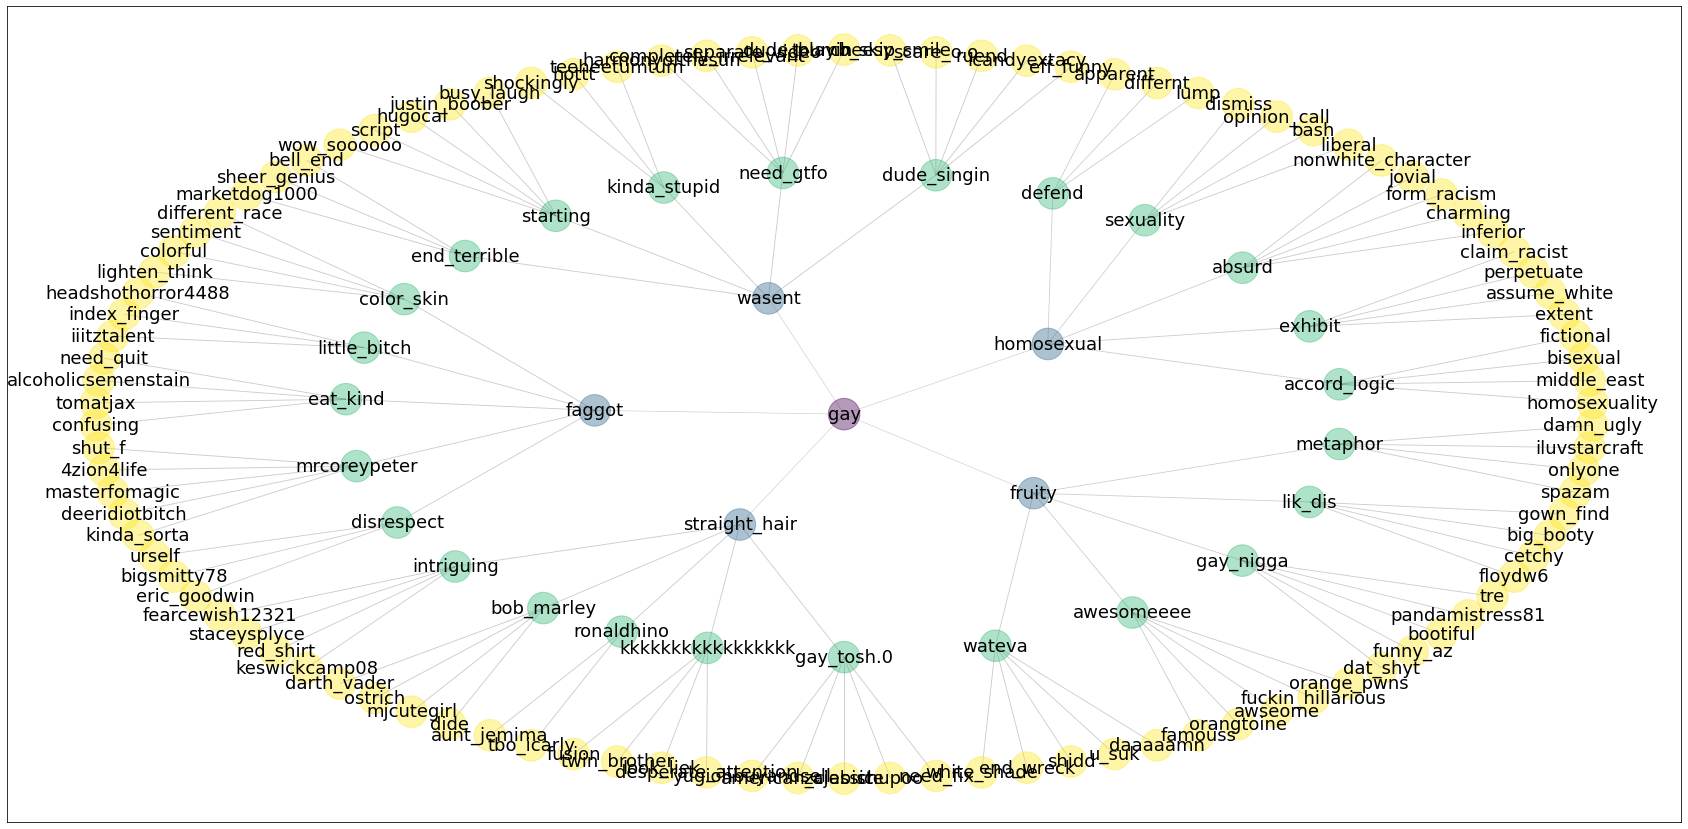

In [ ]:
plt.figure(figsize=(30,15))
graph = sim_tree(modelFastText, 'gay', top_n=5, max_dist=3)
plot_tree(graph, node_size=1000, font_size=18)

In [2]:
!pip install python-pptx

     |████████████████████████████████| 10.1 MB 2.4 MB/s eta 0:00:01
  Created wheel for python-pptx: filename=python_pptx-0.6.21-py3-none-any.whl size=470951 sha256=749576d66b73562f4a93dd75a796577f5568e1980fd355d291fc171d84de7c32
  Stored in directory: /Users/abhinavbajpai/Library/Caches/pip/wheels/0e/4a/ed/9653bc799915f52dce3f04d14946fbd85cce9c3cdedc9cfa71
Successfully built python-pptx


In [ ]:
from pptx import Presentation 
from pptx.util import Inches

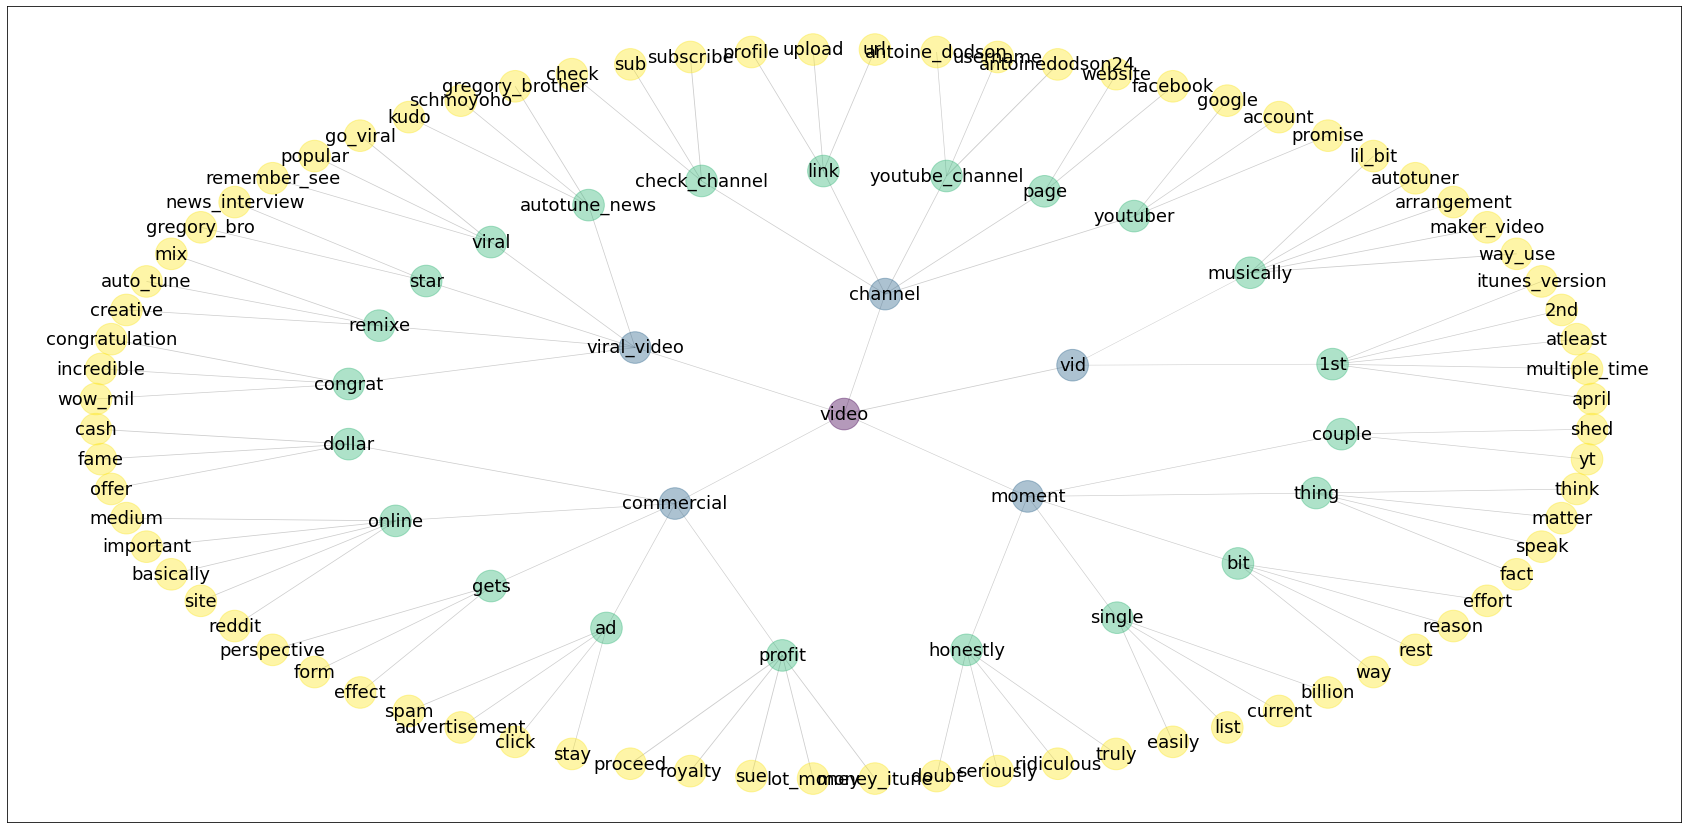

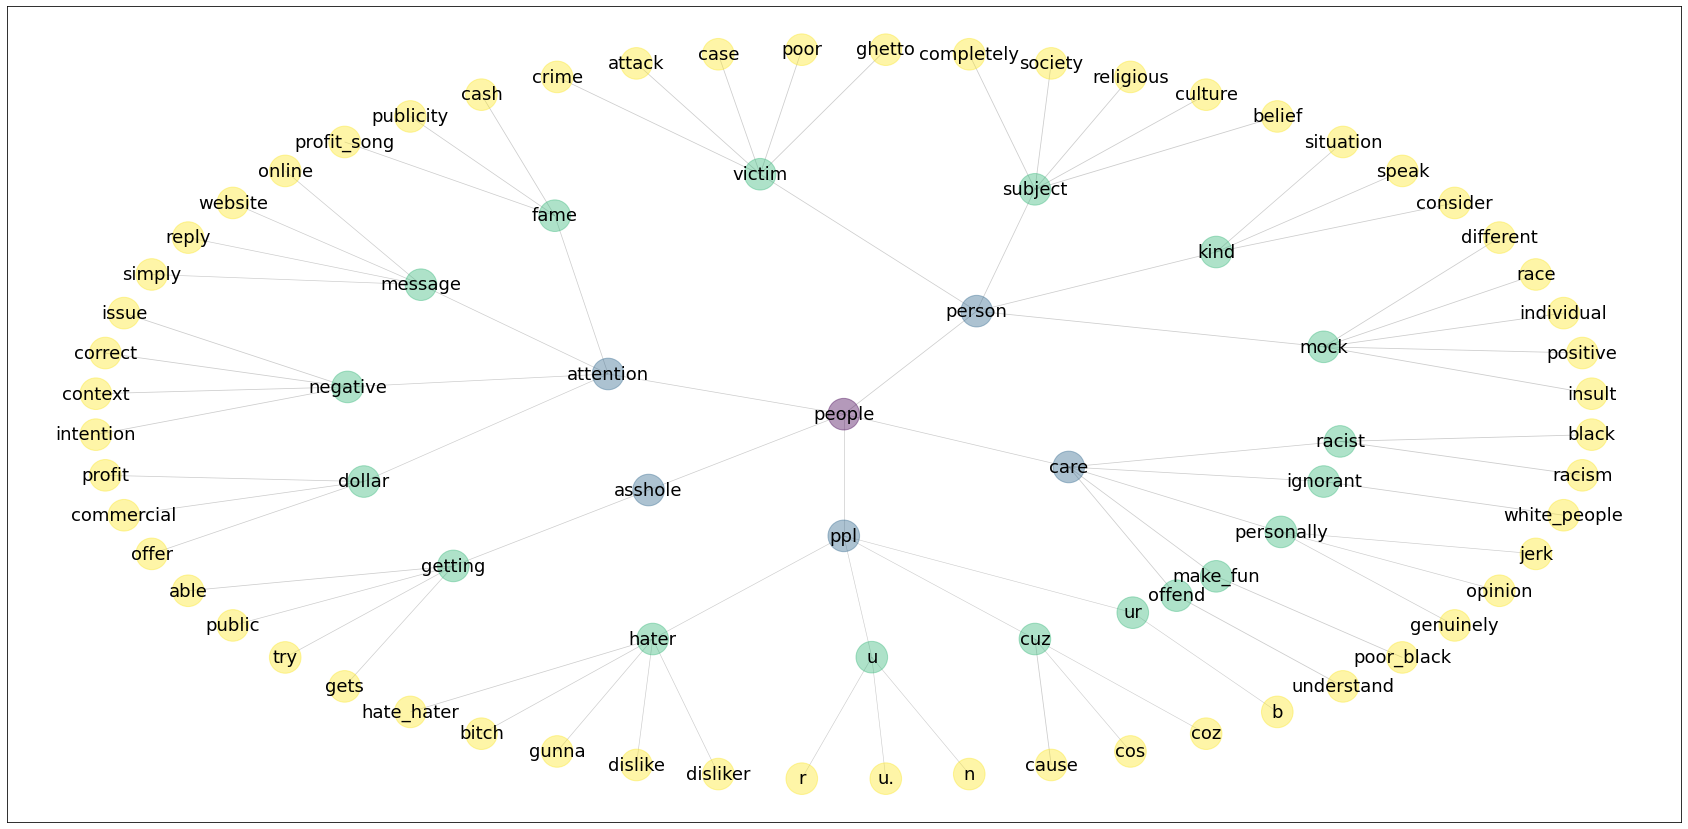

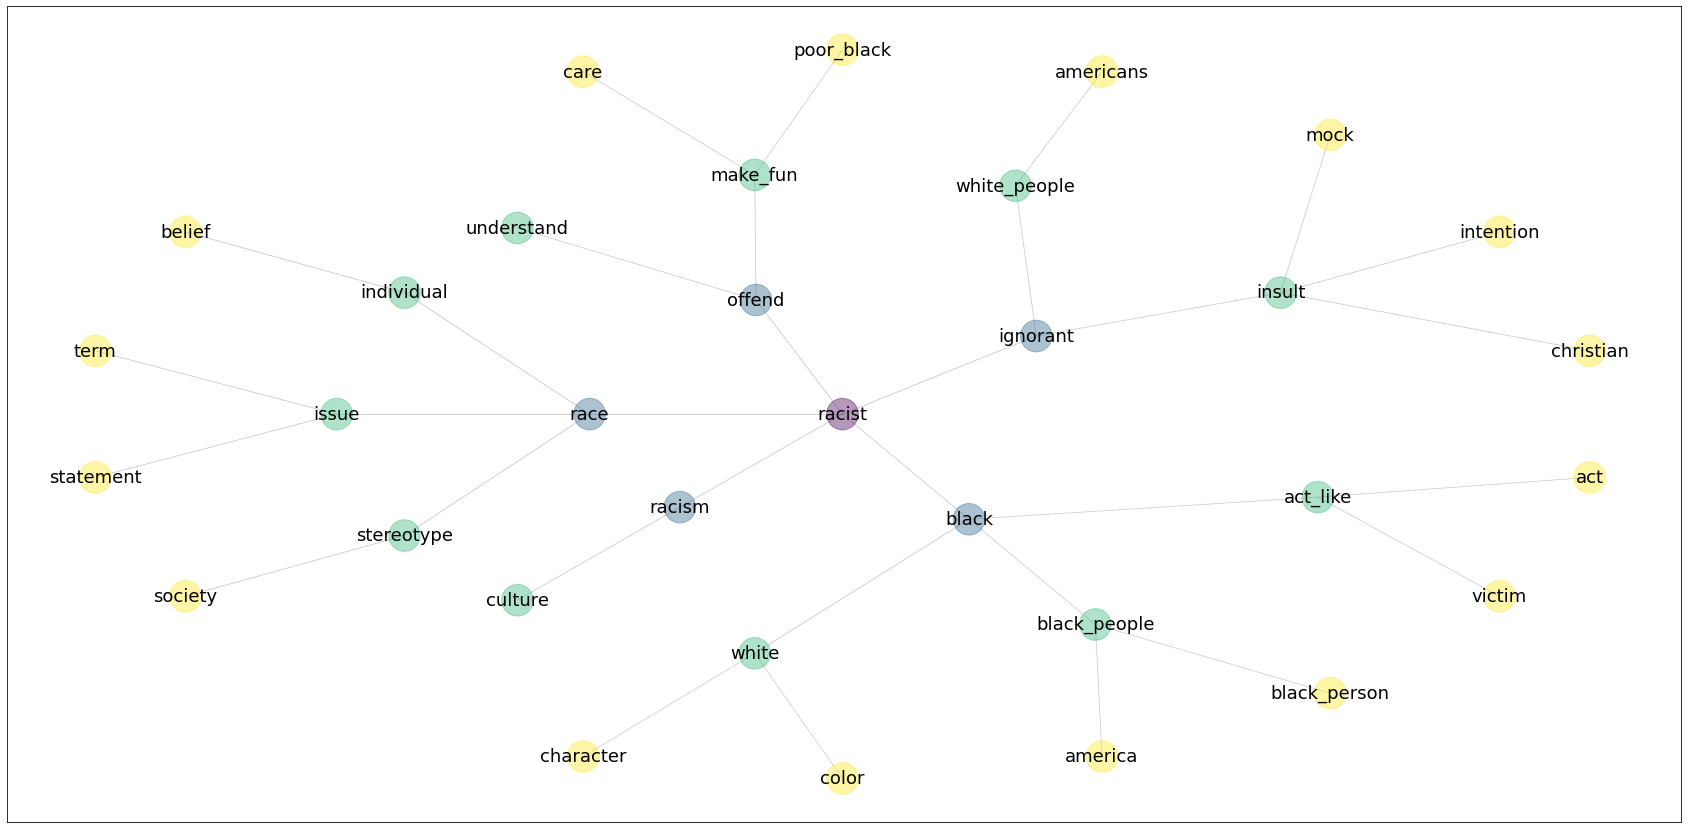

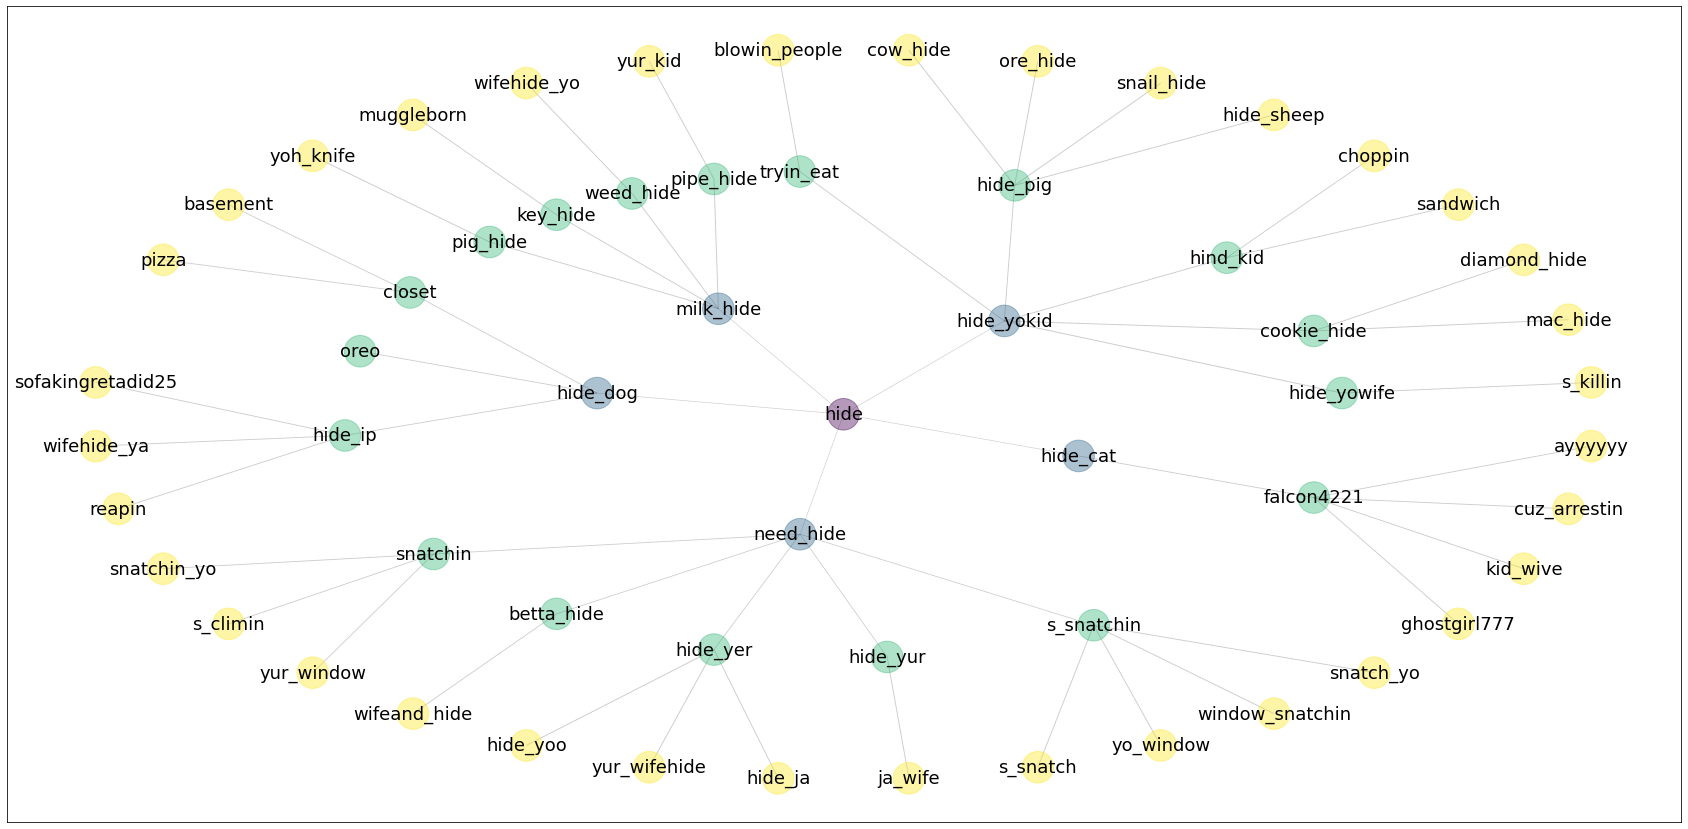

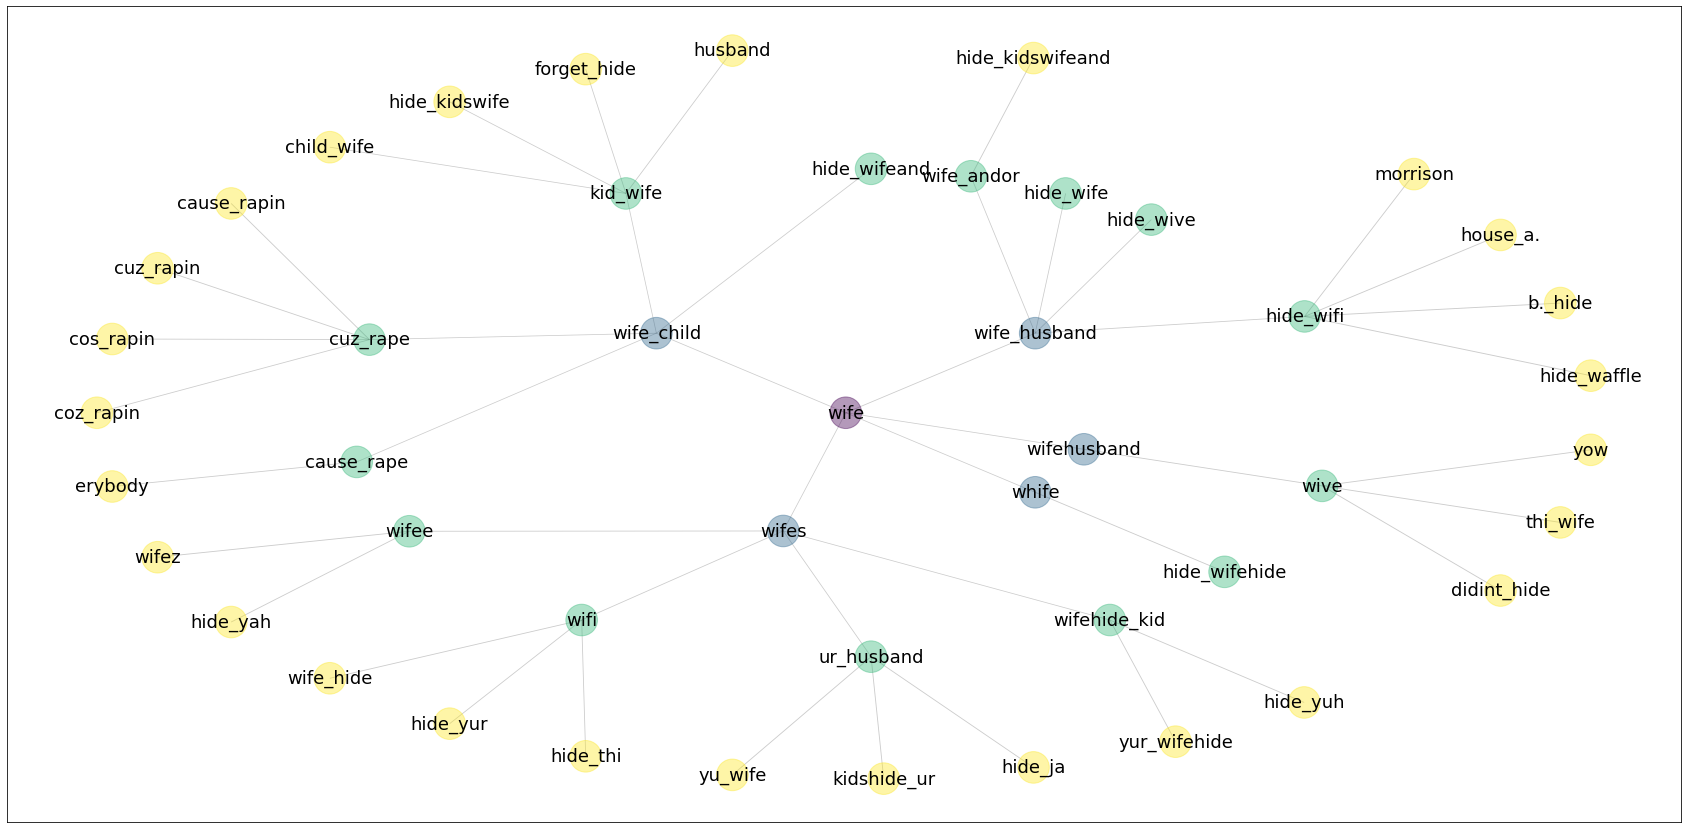

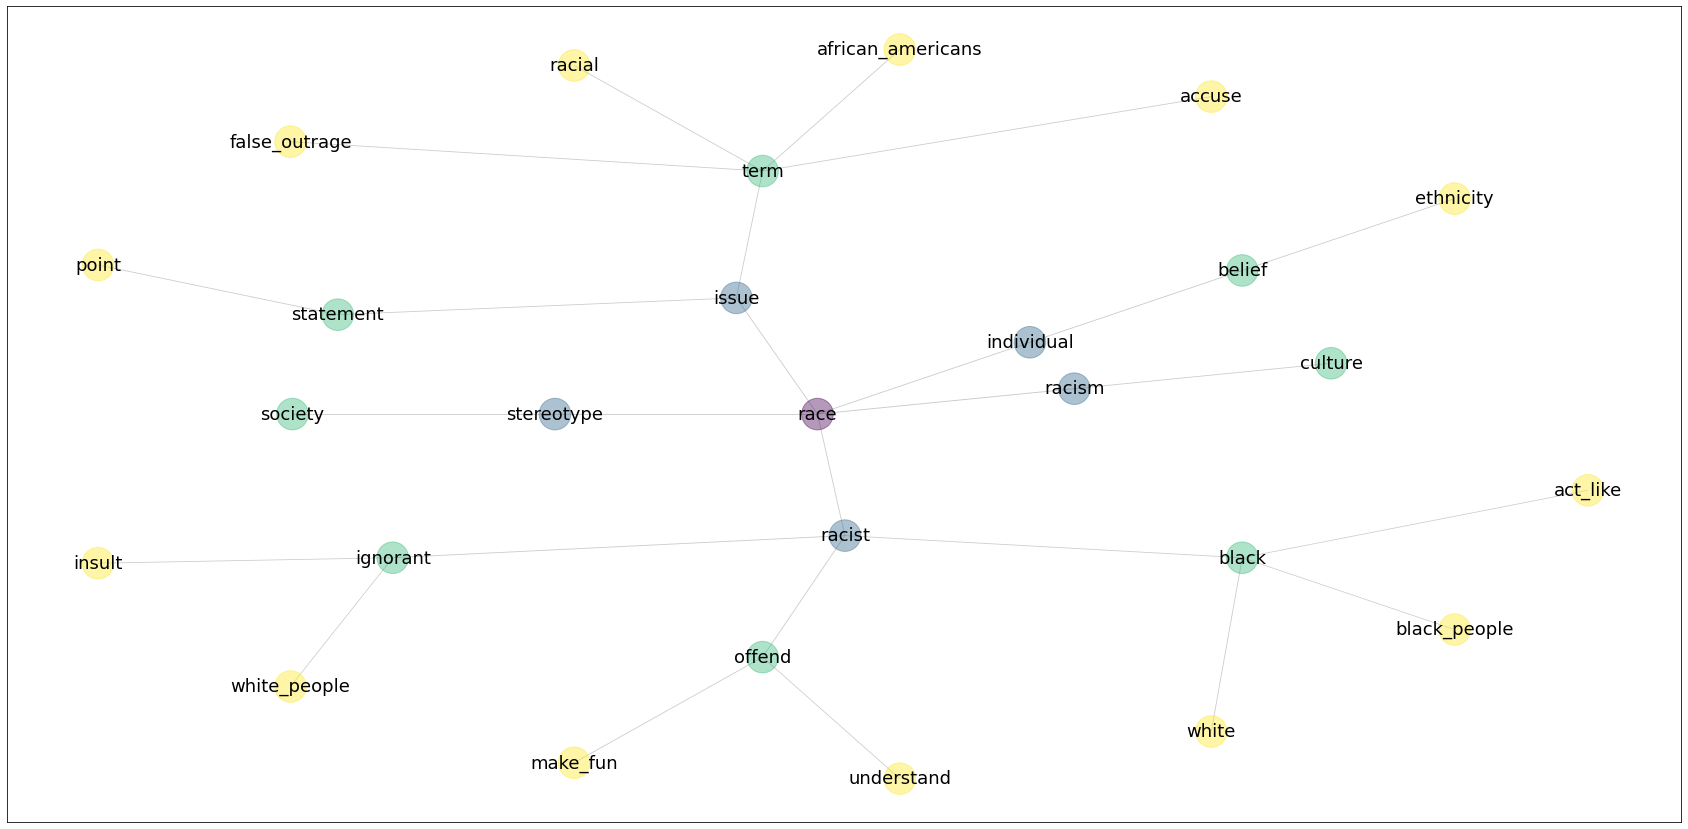

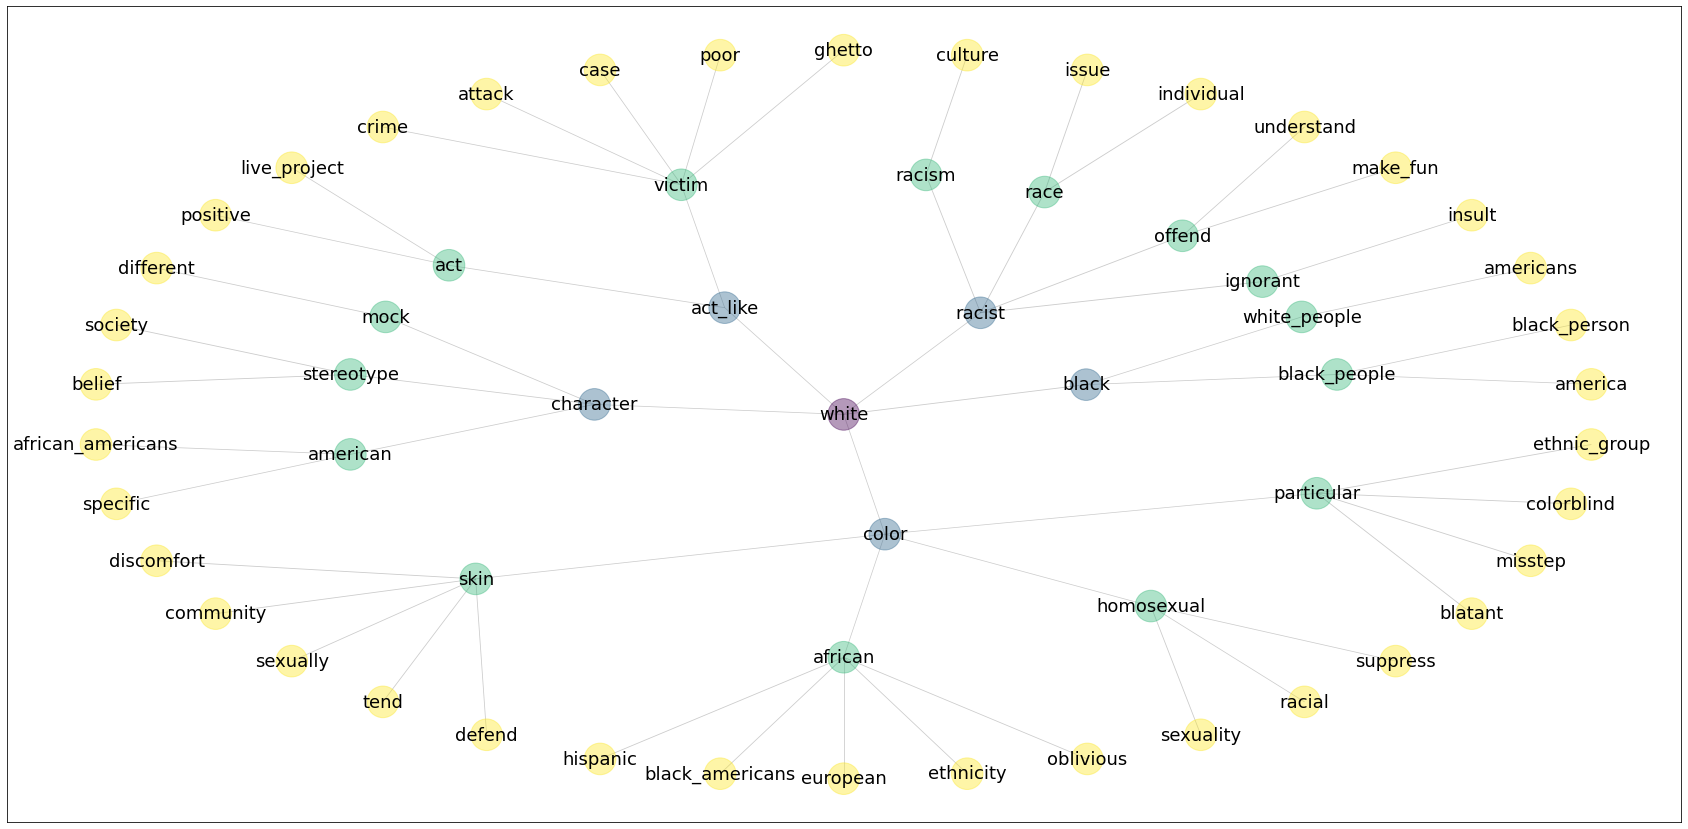

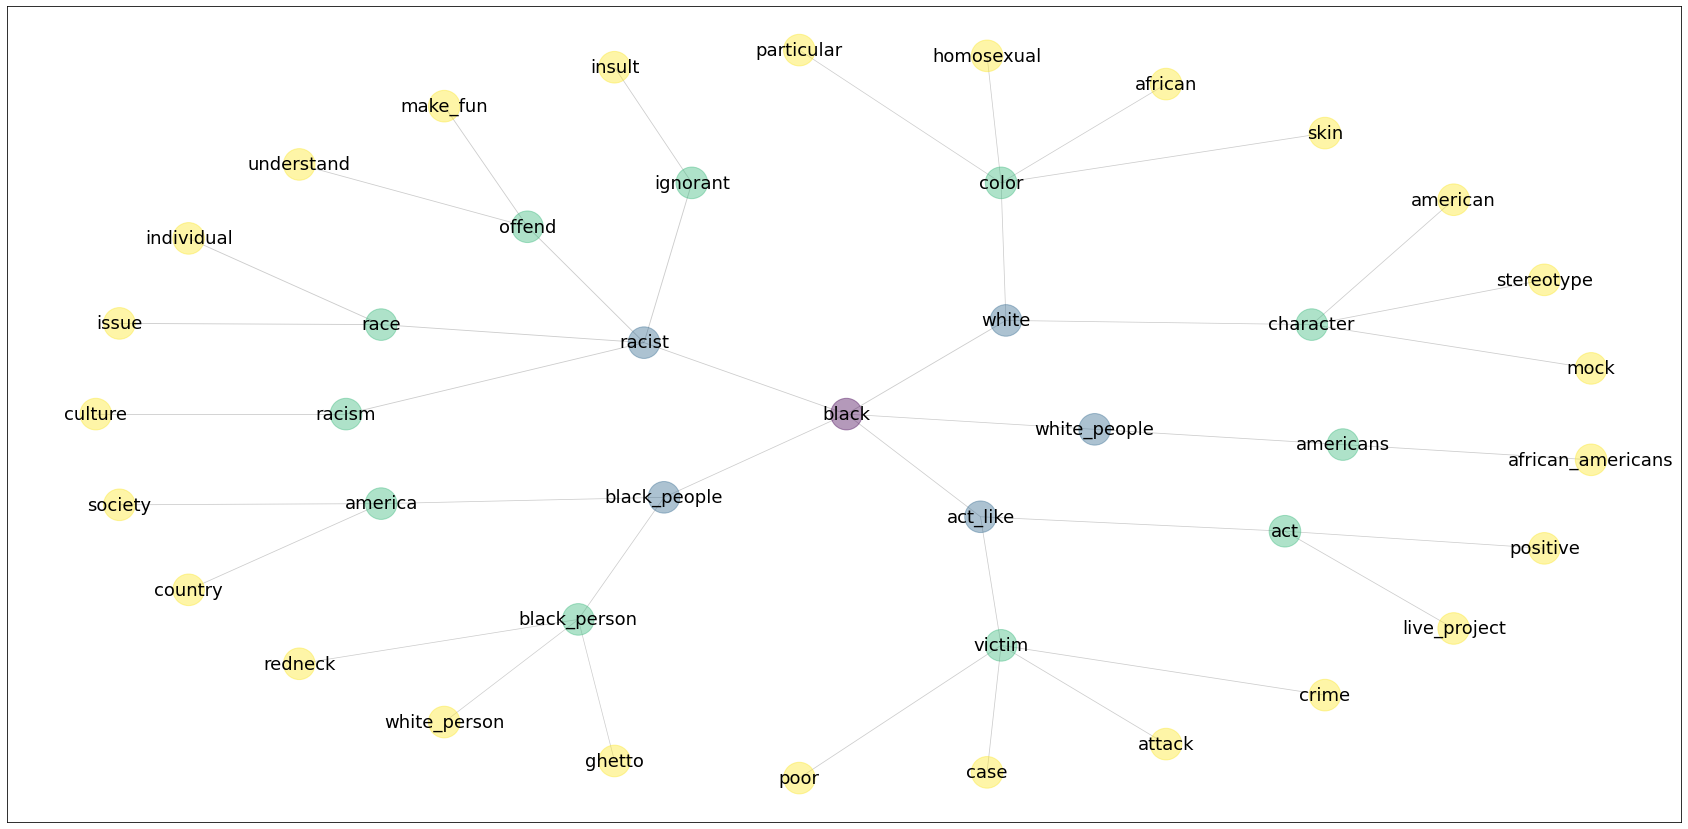

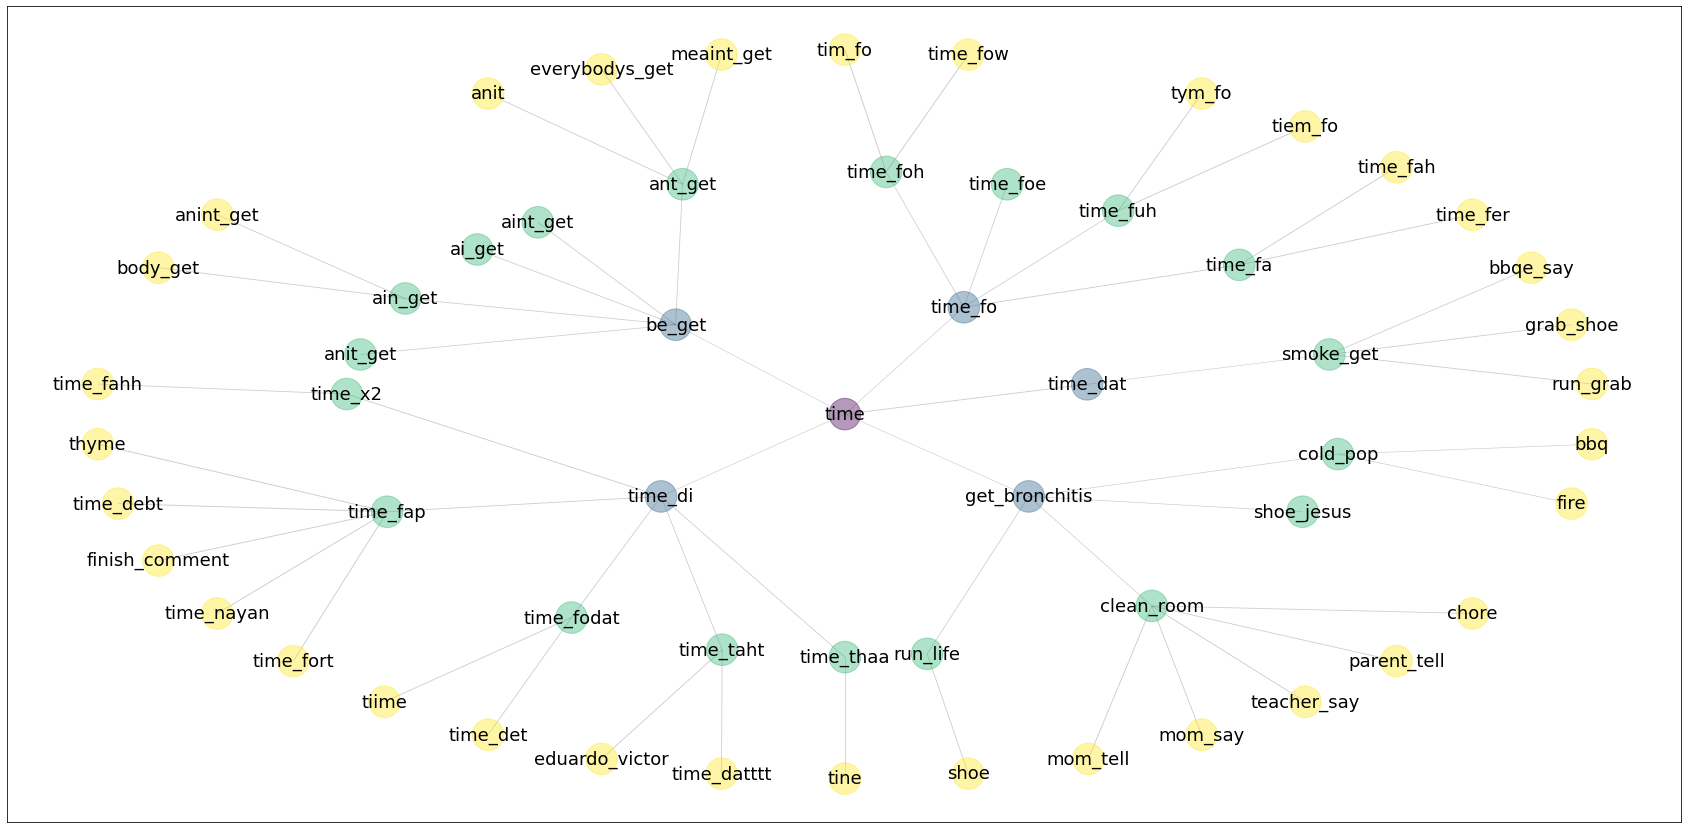

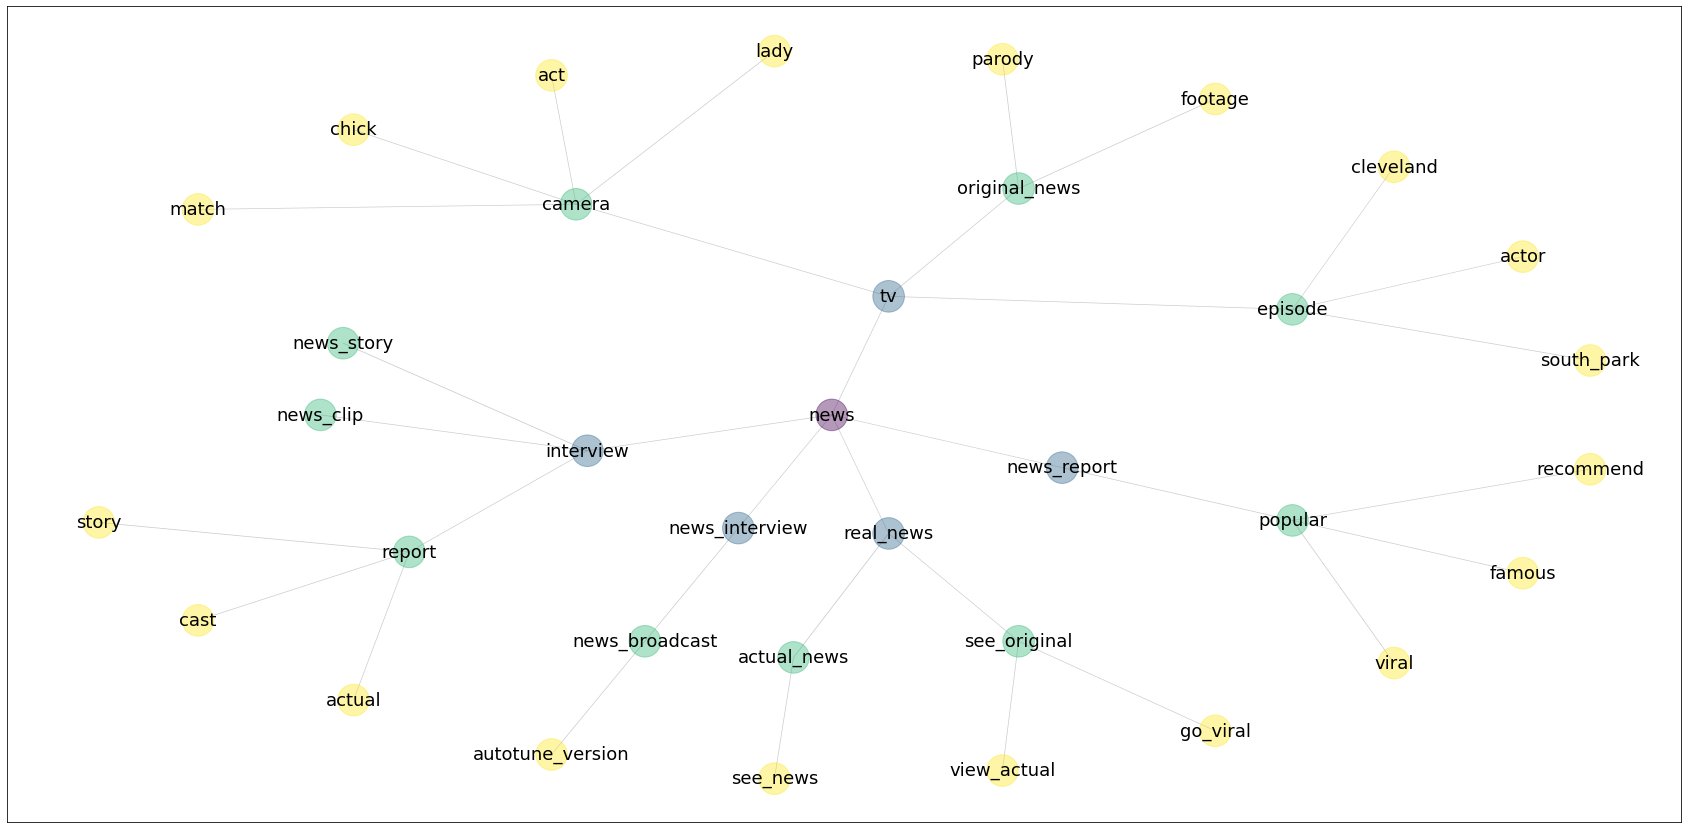

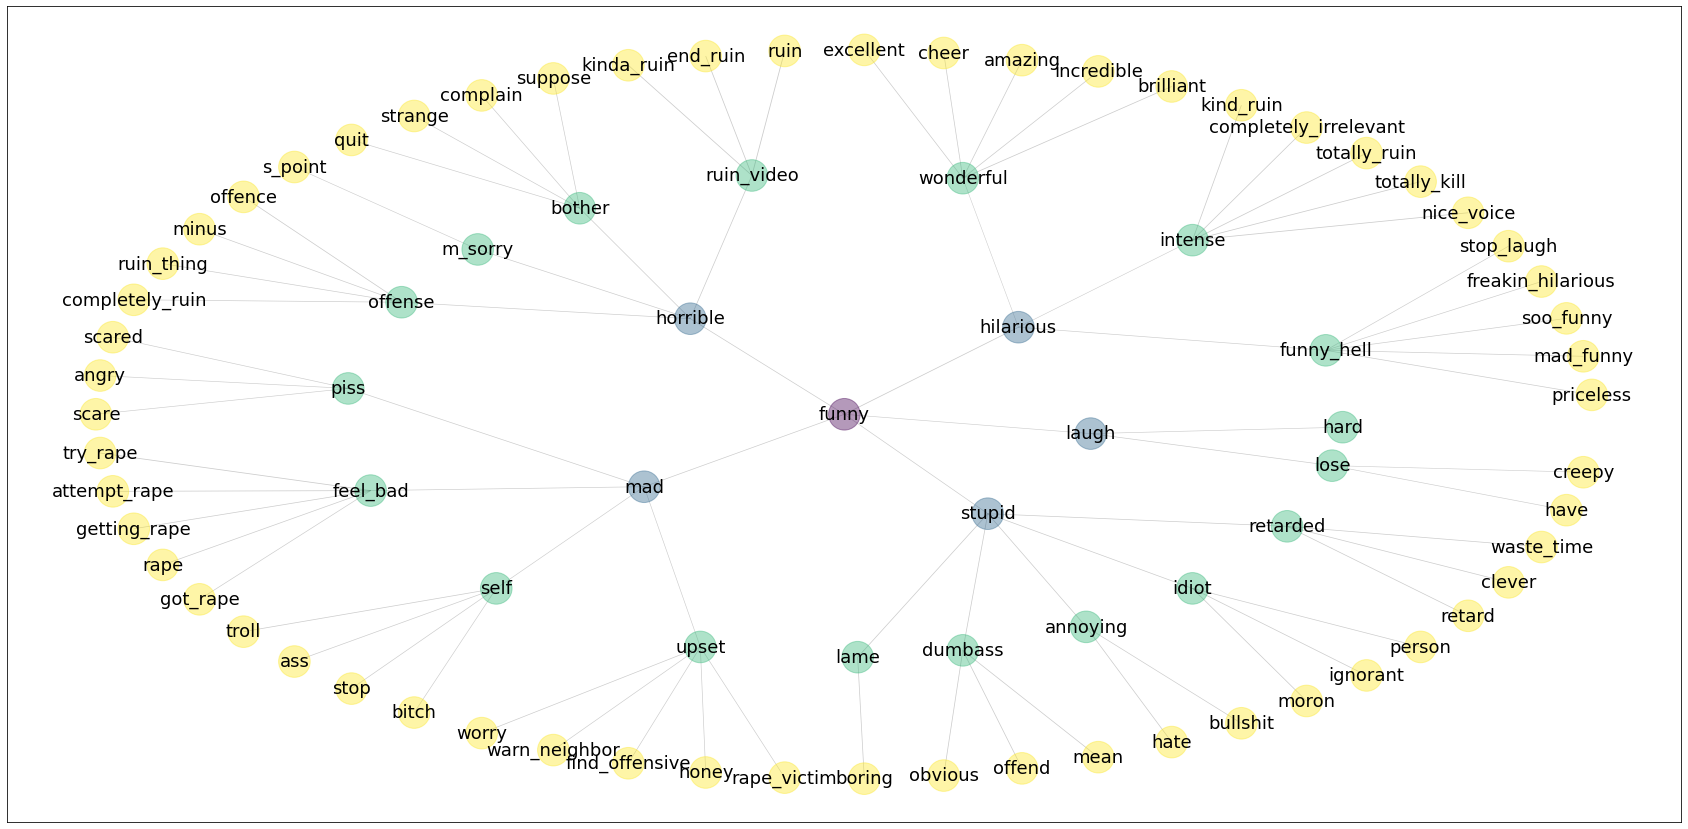

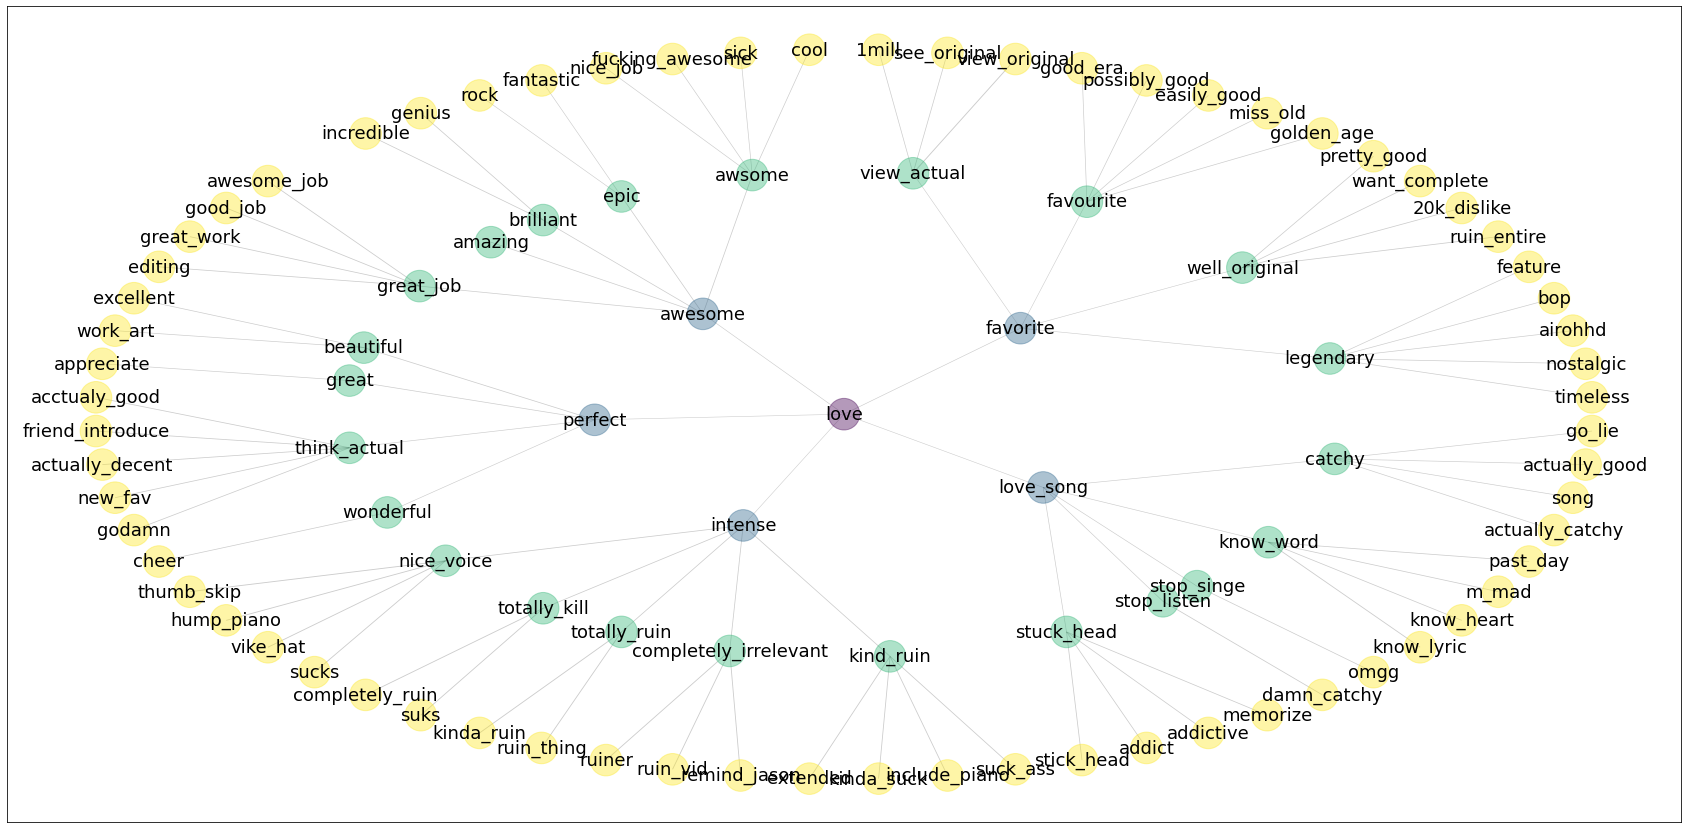

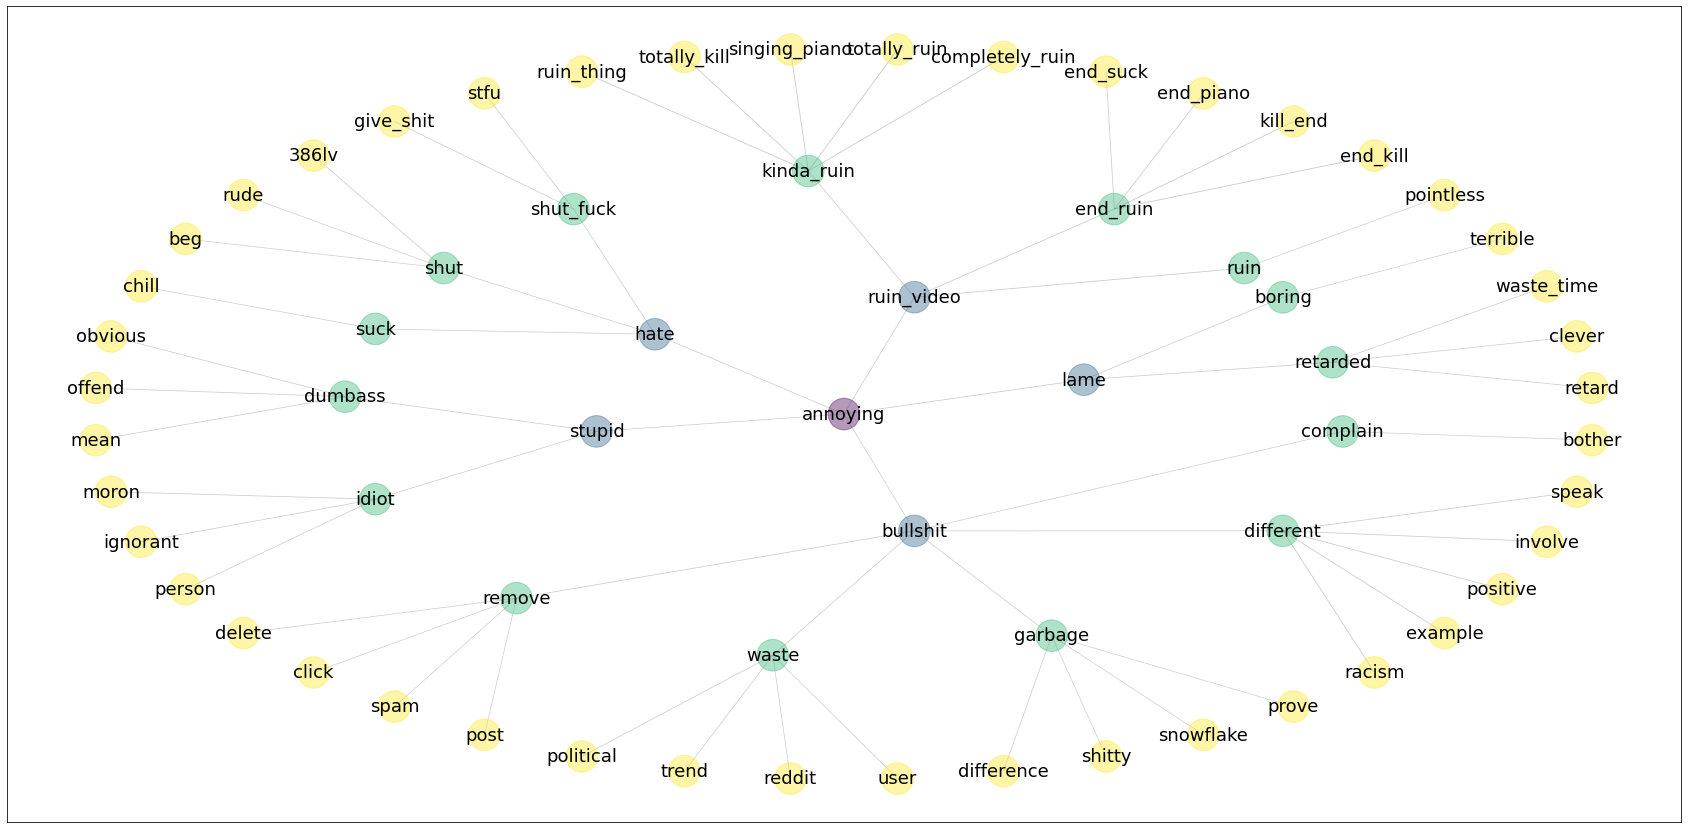

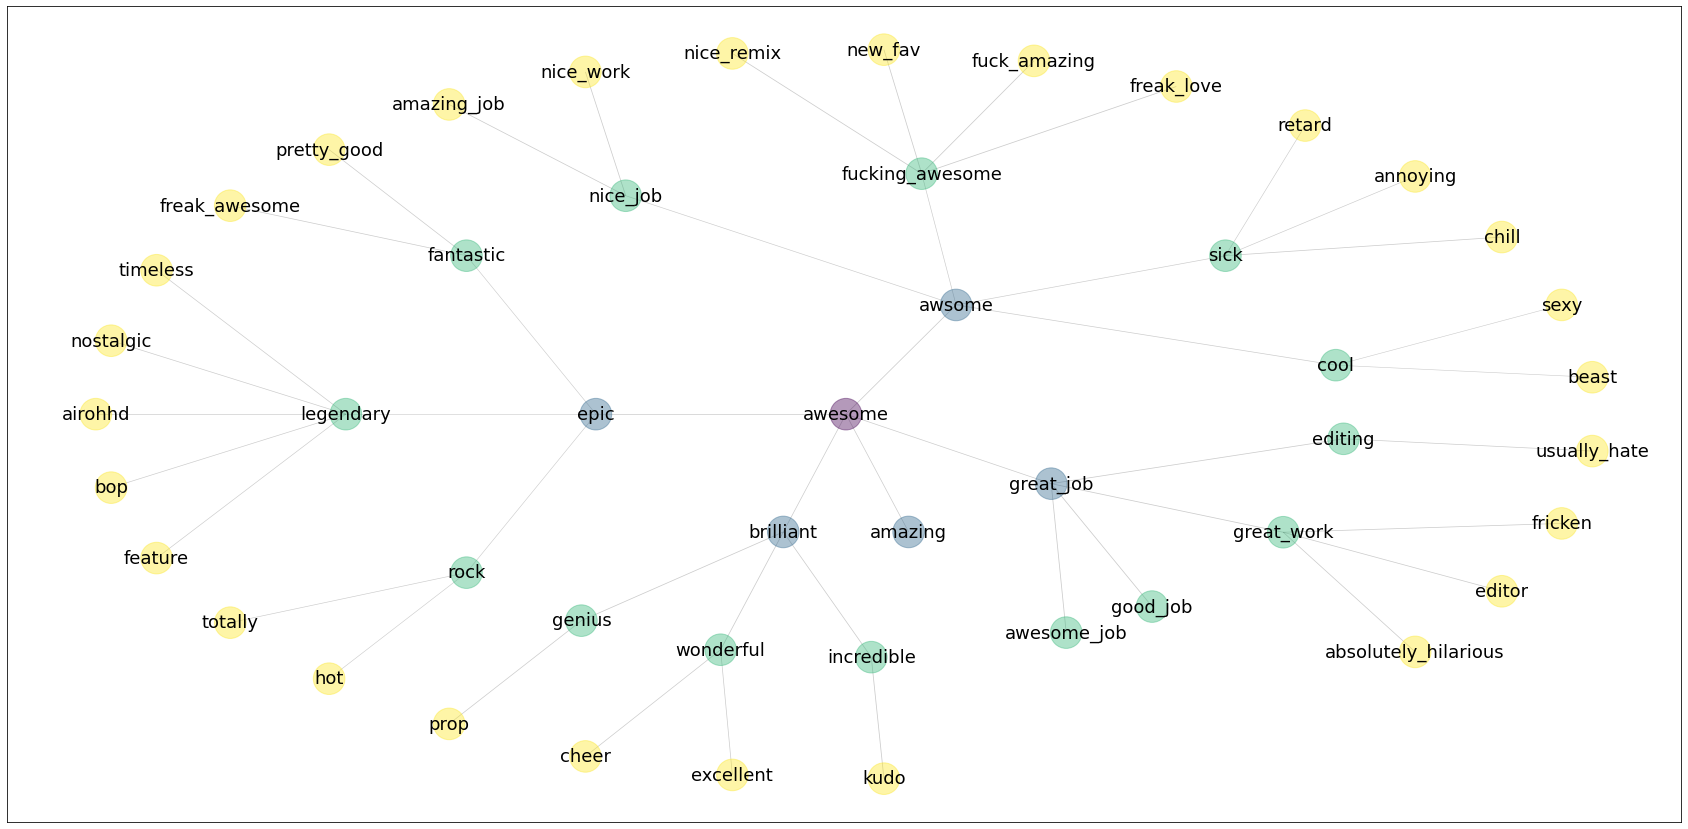

In [ ]:

# list of words
list_words = ['video','people', 'racist','hide', 'wife', 'race', 'white', 'black', 'time', 'news', 'funny', 'love','annoying','awesome']
# Creating an Presentation object
ppt = Presentation() 

for words in list_words:
  
  plt.figure(figsize=(30,15))
  graph = sim_tree(model, words, top_n=5, max_dist=3)
  img = plot_tree(graph, node_size=1000, font_size=18)
  plt.savefig(os.path.join(path, 'word plot.png'),bbox_inches='tight', dpi=300)

  img_path = os.path.join(path, 'word plot.png')

  # Selecting blank slide
  blank_slide_layout = ppt.slide_layouts[6] 
  
  # Attaching slide to ppt
  slide = ppt.slides.add_slide(blank_slide_layout) 

  # creating textBox
  txBox = slide.shapes.add_textbox(left=.05, top=.1,
                                  width=4, height =1)
  # creating textFrames
  tf = txBox.text_frame
  tf.text = f'Keyword : {words}'
      
  # For margins
  left = Inches(.2)
  top = Inches(.5) 
  height = Inches(6.5) 
  width = Inches(9.5)  
  pic = slide.shapes.add_picture(img_path, left,
                                  top, height = height, width=width)
# save file
ppt.save( os.path.join(path,'Top Word Network.pptx'))  